In [1]:
!pip install scikit-uplift catboost==0.22 -U

     |████████████████████████████████| 64.4 MB 9.5 kB/s 


In [2]:
!pip install causalml

     |████████████████████████████████| 243 kB 6.9 MB/s 
     |████████████████████████████████| 326 kB 51.2 MB/s 
     |████████████████████████████████| 1.8 MB 51.7 MB/s 
     |████████████████████████████████| 678 kB 56.8 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496027 sha256=c571c4837b7aed623bb2753b31814fb8f1c49fd62f663d60561e00b2a61205eb
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465076 sha256=4c9518a35138a1850f502c61403ba6258c0a23eeb7c82afe76738415bf188243
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


- скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

- там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

- сделать разбиение набора данных не тренировочную и тестовую выборки

- сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

- провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

- в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

- (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

- (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/ML_in_business/data.csv')

In [6]:
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [7]:
data.offer.value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

In [8]:
data.conversion.value_counts()

0    54606
1     9394
Name: conversion, dtype: int64

In [9]:
data.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)

In [10]:
data.head(2)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0


No offer - не было коммуникации

Discount - была коммуникация 

Buy one get one - была коммуникация 

In [11]:
data['treatment'] = data['treatment'].replace(
    {'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})

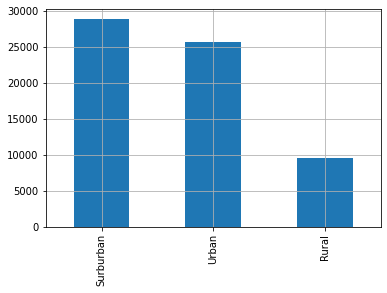

In [12]:
data.zip_code.value_counts().plot(kind = 'bar', grid=True)

In [13]:
data['zip_code'] = data['zip_code'].replace(
    {'Surburban': 1, 'Urban': 2, 'Rural': 3})

In [14]:
data['channel'] = data['channel'].replace(
    {'Web': 1, 'Phone': 2, 'Multichannel': 3})

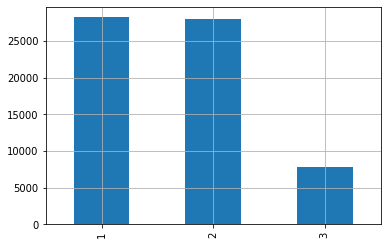

In [15]:
data.channel.value_counts().plot(kind = 'bar', grid=True)

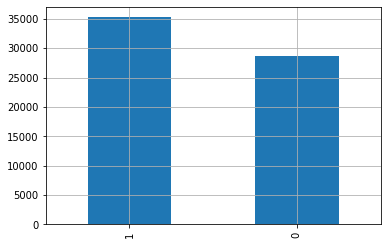

In [16]:
data.used_discount.value_counts().plot(kind = 'bar', grid=True)

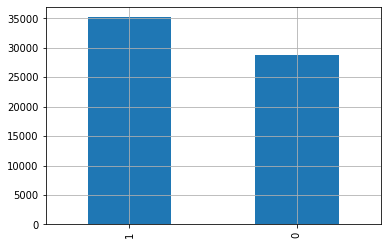

In [17]:
data.used_bogo.value_counts().plot(kind = 'bar', grid=True)

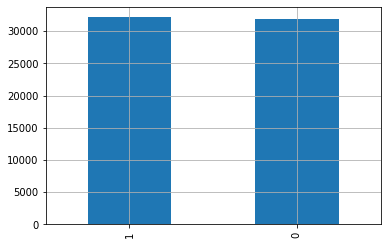

In [18]:
data.is_referral.value_counts().plot(kind = 'bar', grid=True)

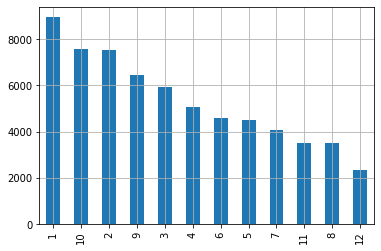

In [19]:
data.recency.value_counts().plot(kind = 'bar', grid=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  int64  
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  int64  
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 4.4 MB


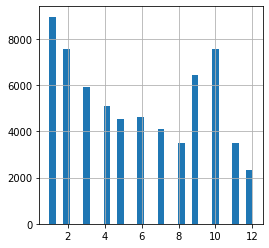

In [21]:
data.loc[:, 'recency'].hist(figsize=(4, 4), bins=30, grid=True)

Применим логарифмическое преобразование, чтобы сделать распределение нормальным. Сдвинем на +1, чтобы избежать логарифм в нуле 

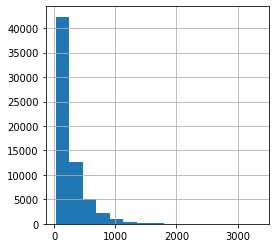

In [22]:
data.loc[:, 'history'].hist(figsize=(4, 4), bins=15, grid=True)

In [23]:
data['history_log'] = np.log(data['history'] + 1.1)

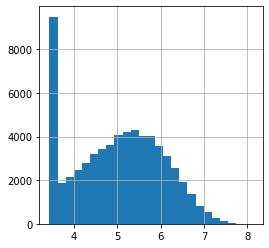

In [24]:
data.loc[:, 'history_log'].hist(figsize=(4, 4), bins=25, grid=True)

Гипотеза: возможно, стоит как-то уменьшить значения самого первого столбца, чтобы нормализовать распределение. 

In [25]:
data.columns.to_list()

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'zip_code',
 'is_referral',
 'channel',
 'treatment',
 'target',
 'history_log']

In [26]:
features = ['recency', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel', 'treatment',
             'target', 'history_log']

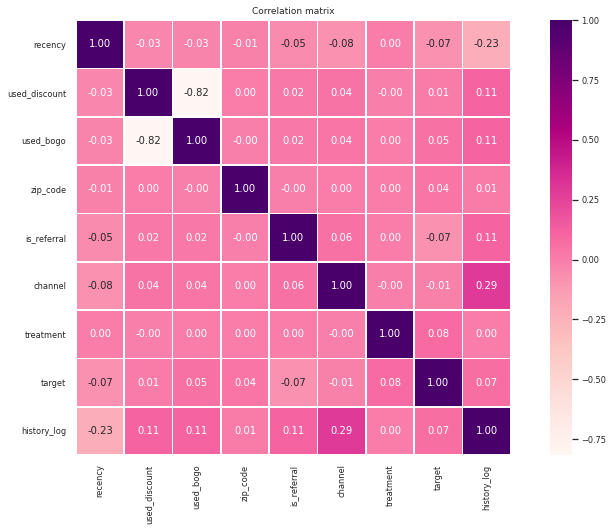

In [27]:
import seaborn as sns
plt.figure(figsize = (14,8))

sns.set(font_scale=0.75)
sns.heatmap(data[features].corr().round(3), annot=True, square = True, linewidths=.75, cmap='RdPu', fmt = '.2f',annot_kws = {"size": 10} )

plt.title('Correlation matrix')
plt.show()

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
# У нас нет id, только индексы. Перемешаем их. 

In [30]:
indices_learn, indices_valid = train_test_split(data.index, test_size=0.3, random_state=123)
indices_learn, indices_valid

(Int64Index([53181, 42635,  6296, 41722, 32660, 14730, 40469, 49818, 51773,
             34850,
             ...
             63594,  7763, 15377, 63206, 54370, 61404, 17730, 28030, 15725,
             52734],
            dtype='int64', length=44800),
 Int64Index([19593,  4997, 36682, 29881, 25401, 41888,  4353, 33487, 63951,
             35285,
             ...
             41382, 46836, 36489, 13683, 10904, 39655, 45479, 21007, 39923,
             61435],
            dtype='int64', length=19200))

In [31]:
train_features = data.copy().drop(['target', 'treatment'], axis=1)
train_features

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,history_log
0,10,142.44,1,0,1,0,2,4.966614
1,6,329.08,1,1,3,1,1,5.799638
2,7,180.65,0,1,1,1,1,5.202632
3,9,675.83,1,0,3,1,1,6.517568
4,2,45.34,1,0,2,0,1,3.838161
...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,2,0,1,4.669459
63996,5,38.91,0,1,2,1,2,3.689129
63997,6,29.99,1,0,2,1,2,3.436886
63998,1,552.94,1,0,1,1,3,6.317237


In [32]:
X_train = train_features.loc[indices_learn, :]
y_train = data.loc[indices_learn, 'target']
treat_train = data.loc[indices_learn, 'treatment']

X_test = train_features.loc[indices_valid, :]
y_test = data.loc[indices_valid, 'target']
treat_test =  data.loc[indices_valid, 'treatment']

X_train_full = train_features.loc[data.index, :]
y_train_full = data.loc[:, 'target']
treat_train_full = data.loc[:, 'treatment']

In [33]:
result_models = {
    'expirement_type': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [34]:
# import approach
from sklift.models import SoloModel
# import any estimator adheres to scikit-learn conventions
from catboost import CatBoostClassifier

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier, \
                                        uplift_tree_string, uplift_tree_plot
from catboost import CatBoostClassifier
import warnings

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Одна модель с признаком коммуникации (SoloModel) 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b6df2c850>,
      dtype=object)

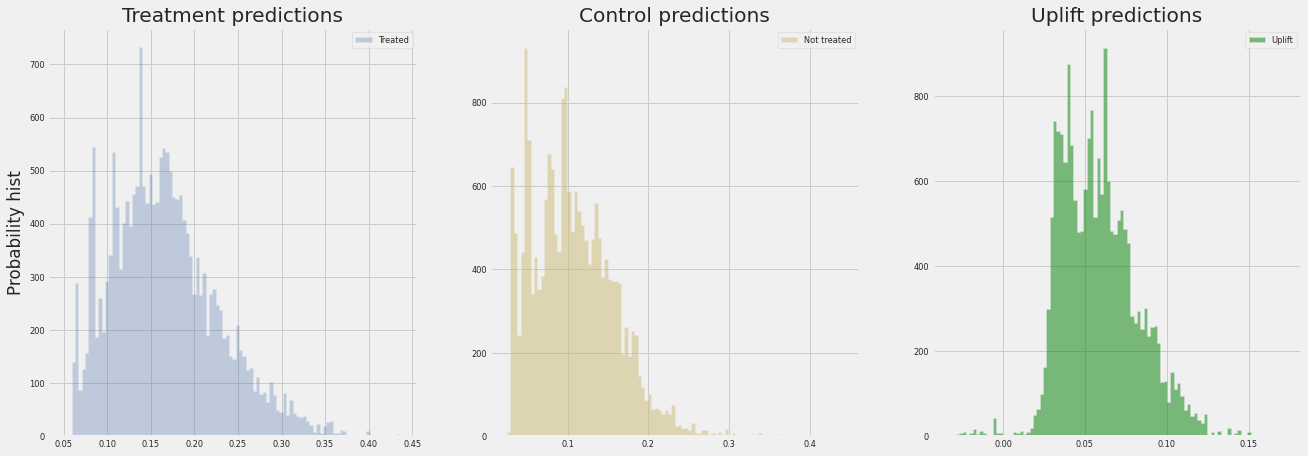

In [36]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': ['used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

result_models['expirement_type'].append('SoloModel')
result_models['uplift@10%'].append(sm_score_10)
result_models['uplift@20%'].append(sm_score_20)

# Условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# Условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Распределение вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

# Трансформация классов

In [37]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': ['used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

result_models['expirement_type'].append('ClassTransformation')
result_models['uplift@10%'].append(ct_score_10)
result_models['uplift@20%'].append(ct_score_20)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


# Две независимые модели

In [38]:
from sklift.models import TwoModels

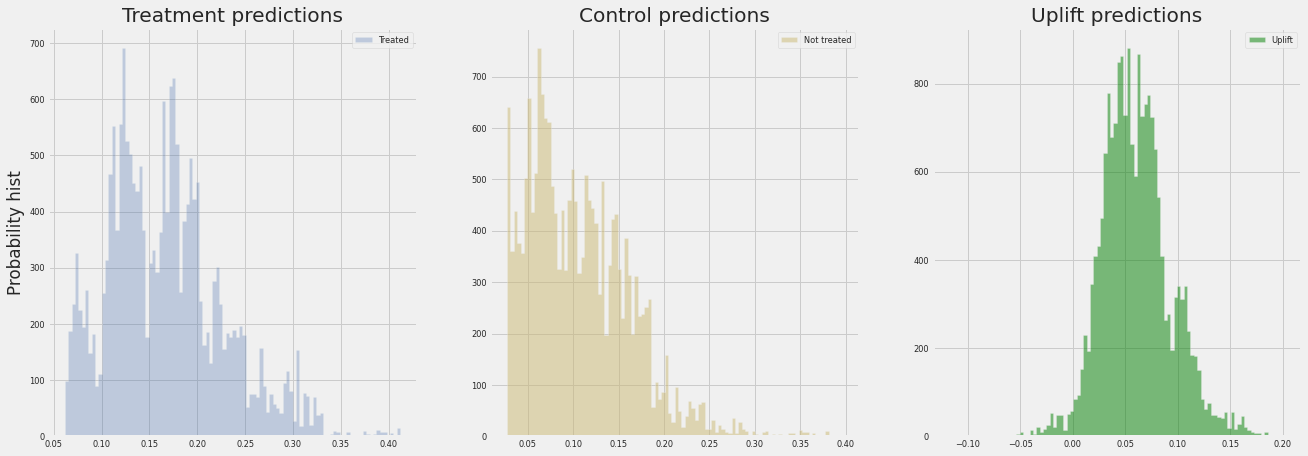

In [39]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': ['used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']}, 
    estimator_ctrl_fit_params={'cat_features': ['used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']}
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

result_models['expirement_type'].append('TwoModels')
result_models['uplift@10%'].append(tm_score_10)
result_models['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [40]:
pd.DataFrame(data=result_models).sort_values('uplift@10%', ascending=False)

,expirement_type,uplift@10%,uplift@20%
1,ClassTransformation,0.118186,0.081342
0,SoloModel,0.100974,0.099307
2,TwoModels,0.068922,0.080547


# Вариант с деревом решений

In [41]:
X_train_tree = X_train.copy()
features = [col for col in X_train_tree]
X_train_tree.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,history_log
53181,8,121.56,0,1,1,0,1,4.809416
42635,9,617.62,0,1,2,1,2,6.427653
6296,5,185.62,1,0,3,1,1,5.229610
41722,1,359.03,0,1,3,0,1,5.886465
32660,10,139.68,1,0,2,0,1,4.947198


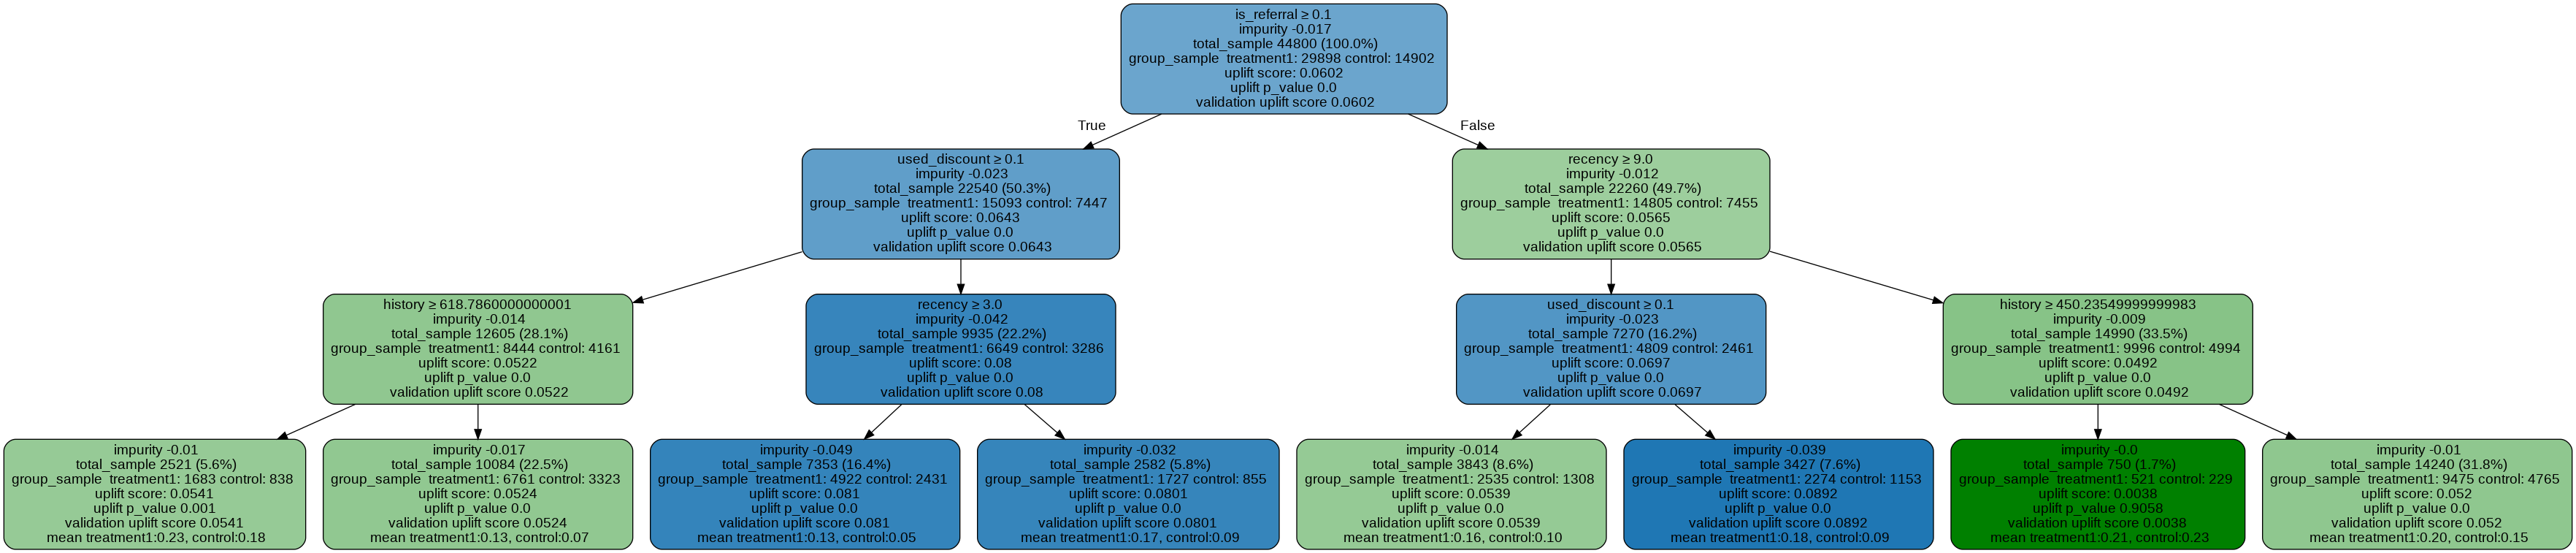

CPU times: user 2.04 s, sys: 50.7 ms, total: 2.09 s
Wall time: 2.4 s


In [42]:
%%time
from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))

In [43]:
y_tree = uplift_model.predict(X_train_tree.values)

In [44]:
y_tree[1][:5]

[0.200844, 0.130232, 0.125869, 0.200844, 0.157002]